In [12]:
from pathlib import Path
import os

import xarray as xr
import numpy as np
import fsspec
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # noqa
import echoregions as er

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

In [2]:
import_path = Path('example_data/NWFSC_2017_hake_survey_transect_with_hake/')

output_dpath = Path('./exports/hake_notebook_outputs')
output_dpath.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = Path(output_dpath / 'hake_survey_echodata_zarr')
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = Path(output_dpath / 'combined_zarr')
combined_zarr_path.mkdir(exist_ok=True)

In [3]:
ncei_2017_ek60_raws_path = "ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60"
transect_name = "x0045_0_wt_20170717_213507_f0010"
transect_file_paths = []
with open(import_path / transect_name, 'r') as file:
    for line in file:
        transect_file_paths.append(
            f"{ncei_2017_ek60_raws_path}/{line.strip()}.raw"
        )

In [4]:
transect_file_paths

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T212115.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T214833.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T221909.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T224632.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T231028.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T233247.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T235306.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T001206.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T003054.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T004846.raw']

In [5]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count())
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


In [6]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in transect_file_paths:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 997 ms, sys: 238 ms, total: 1.24 s
Wall time: 6.33 s


In [7]:
%%time

# Open Zarr Stores containing Echodata Objects, Lazy Load them, and Lazily Combine Echodata Objects
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save to Zarr and offload computation to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazily Open Zarr
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

CPU times: user 13.4 s, sys: 1.36 s, total: 14.7 s
Wall time: 18 s


In [8]:
%%time

# Chunk Echodata Object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 1.81 s, sys: 262 ms, total: 2.07 s
Wall time: 2.71 s


In [9]:
%%time
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='1m',  # in meters
    ping_time_bin='5s',  # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 5.05 s, sys: 568 ms, total: 5.61 s
Wall time: 12.4 s


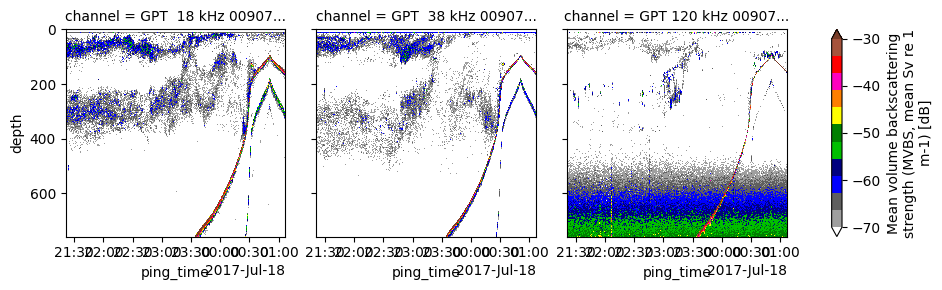

In [28]:
# Plot the all frequency channels of the MVBS dataset
ds_MVBS["Sv"].plot.pcolormesh(
    col="channel",
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
)

### Create Transect Mask using Echoregions

In [41]:
# Parse Echoview Regions File
regions2d = er.read_evr(import_path / "x0045_regions.evr")

In [84]:
# Create Transect Mask
transect_mask_da = regions2d.transect_mask(ds_MVBS["Sv"])

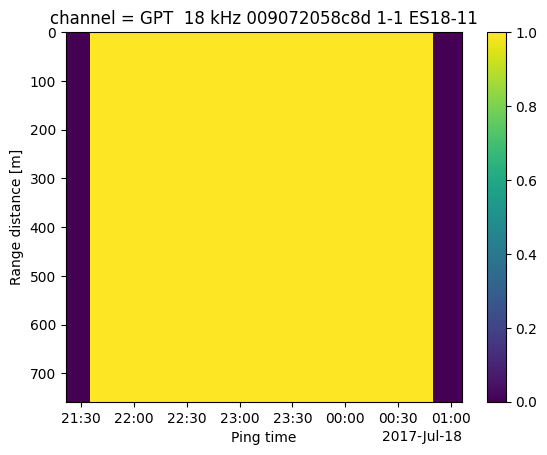

In [85]:
# Plot Transect Mask
transect_mask_da.plot(y="depth", yincrease=False)

In [100]:
# Turn mask with integer values to boolean mask
transect_boolean_mask_da = xr.where(
    transect_mask_da > 0, True, False
).transpose("ping_time", "depth")

### Create Hake Mask using Echoregions

In [46]:
# Grab Hake Regions
hake_regions = regions2d.select_region(region_class="Hake")

In [53]:
# Show Hake Regions
hake_regions

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
16,x0045_regions.evr,EVRG,7,13.0.378.44817,31,13,10,0,2,-1,...,2017-07-18 00:32:38.498500,165.528208,368.620818,Hake,1,H23U-Region31,"[2017-07-18T00:32:38.498500000, 2017-07-18T00:...","[186.0156202136, 174.8811569187, 165.528207751...",[AWT 23 on line 48],[]
17,x0045_regions.evr,EVRG,7,13.0.378.44817,32,13,76,0,2,-1,...,2017-07-17 22:56:03.693500,315.639445,437.42681,Hake,1,H22U-Region32,"[2017-07-17T22:21:22.711000000, 2017-07-17T22:...","[353.1124807396, 353.1124807396, 337.889060092...","[LCH: Agreed., , JG: This looks like the sig...",[]


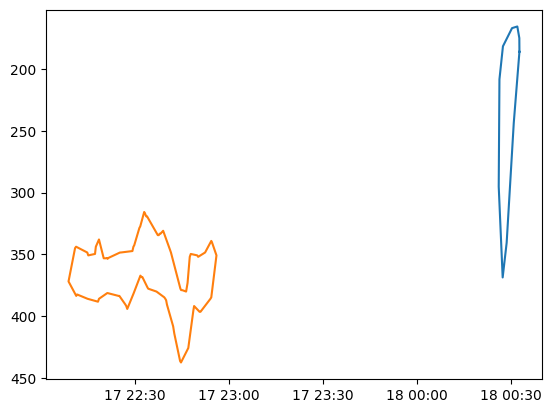

In [55]:
# Plot Closed Hake Regions
hake_regions_closed = regions2d.close_region(region_class="Hake")
for _, row in hake_regions_closed.iterrows():
    plt.plot(row["time"], row["depth"])
plt.gca().invert_yaxis()
plt.show()

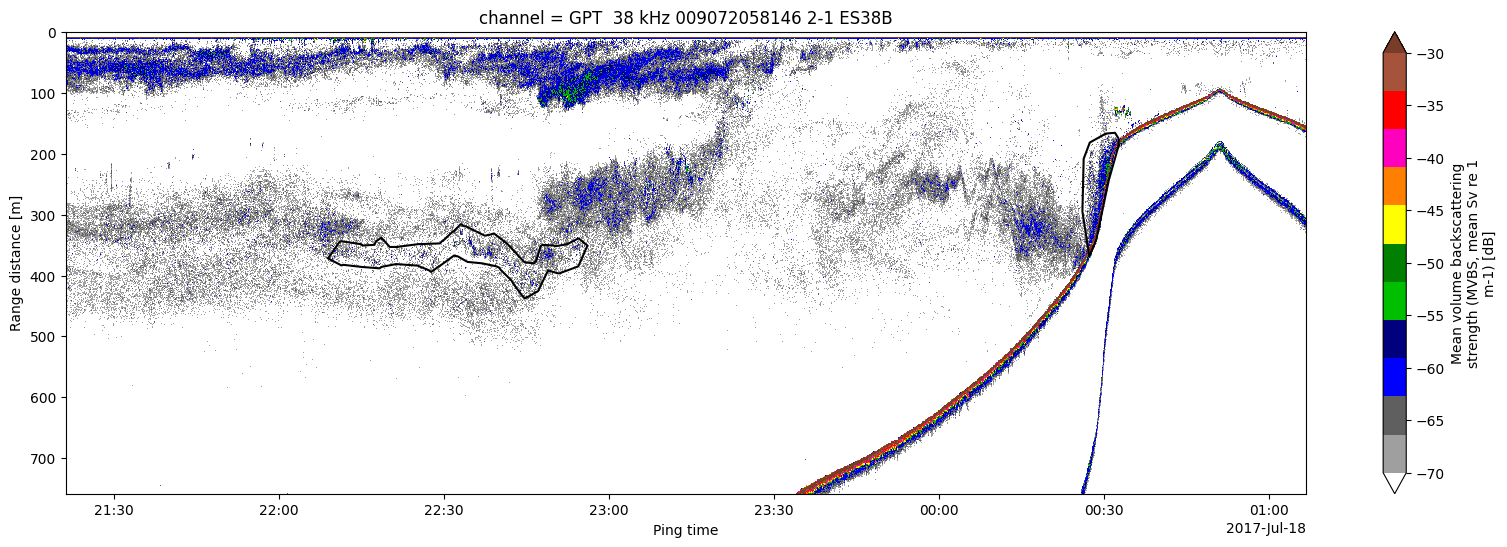

In [52]:
# Plotting the echogram data and the hake regions
plt.figure(figsize=(20, 6))
for _, point in hake_regions_closed.iterrows():
    plt.plot(point["time"], point["depth"], fillstyle='full', markersize=1, color="black")

ds_MVBS["Sv"].isel(channel=1).T.plot(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap="ep.ek500")

In [77]:
# Use the built in mask function to create a mask
hake_mask_ds, hake_region_points = regions2d.region_mask(
    ds_MVBS["Sv"].isel(channel=0).drop_vars("channel").compute(),
    region_class="Hake",
    collapse_to_2d=True,
)

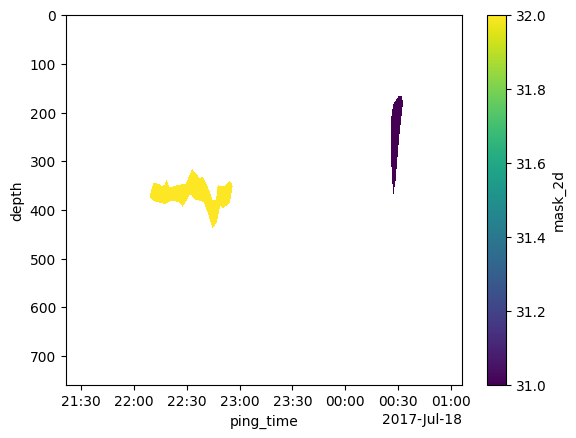

In [79]:
# Plot Hake Regions
hake_mask_ds["mask_2d"].plot(y="depth", yincrease=False)

In [95]:
# Turn mask with integer values to boolean mask
hake_boolean_mask_da = xr.where(
    hake_mask_ds["mask_2d"] > 0, True, False
).transpose("ping_time", "depth")

### Create Bottom Mask using Echoregions

In [17]:
# Parse Echoview Lines File
lines = er.read_evl(import_path / "x0045_lines.evl")

In [11]:
# Grab lines dataframe
lines_df = lines.data

# Get only 'good' bottom points
good_lines_df = lines_df[lines_df['status'] == '3']
good_bottom = good_lines_df[['time', 'depth']]
lines.data = good_lines_df

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


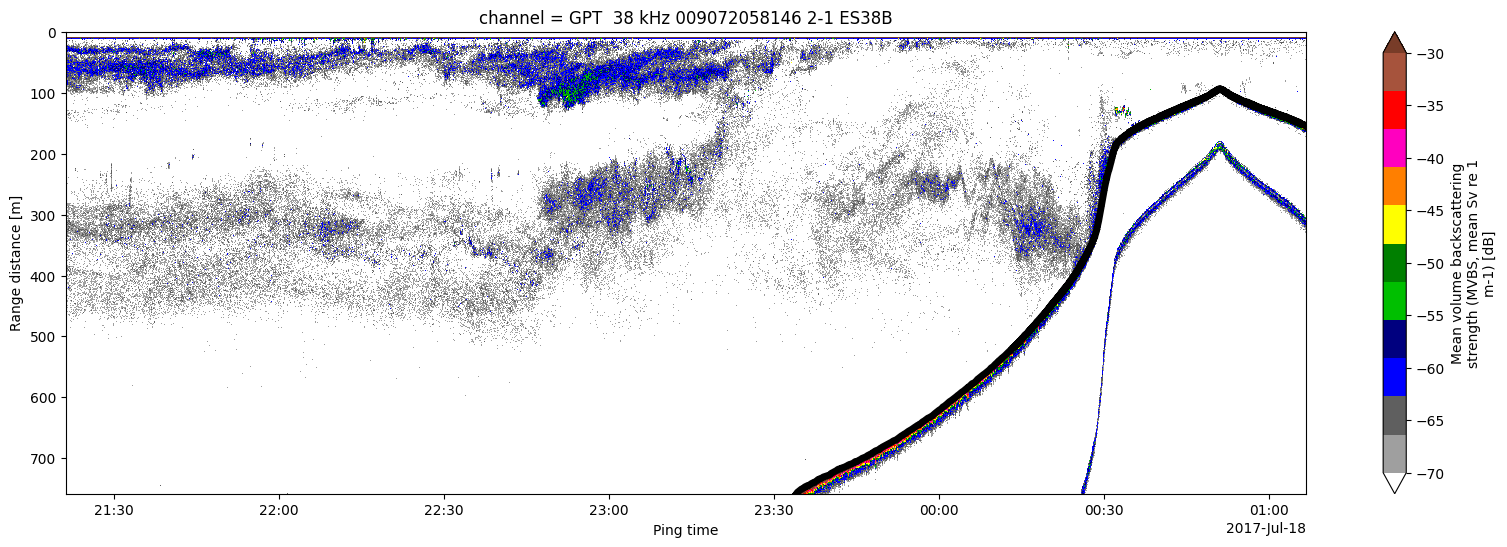

In [51]:
# Plotting the Echogram data and the bottom
plt.figure(figsize = (20, 6))
plt.plot(lines.data['time'], lines.data['depth'], 'black', fillstyle='full', linewidth=5, markersize=1)
ds_MVBS["Sv"].isel(channel=1).T.plot.pcolormesh(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap="ep.ek500")

In [ ]:
# Use the built in mask function
bottom_mask_da, bottom_points = lines.bottom_mask(
    ds_MVBS["Sv"].isel(channel=0).drop_vars("channel").compute(),
    operation="above_below",
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

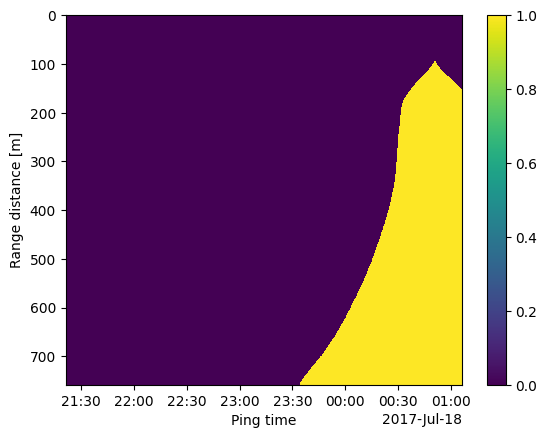

In [38]:
# Plotting the bottom mask
bottom_mask_da.plot(y="depth", yincrease=False)

In [101]:
# Turn mask with integer values to boolean mask
bottom_boolean_mask_da = bottom_mask_da.astype(bool).transpose("ping_time", "depth")

### Apply the Three Masks on the MVBS dataset

In [98]:
# Apply the three masks on MVBS
ds_MVBS_transect_cleaned_hake = ep.mask.apply_mask(
    ds_MVBS,
    [
        #hake_boolean_mask_da.transpose("ping_time", "depth"),
        ~bottom_mask_da.transpose("ping_time", "depth"),
        #transect_mask_da.transpose("ping_time", "depth"),
    ]
)

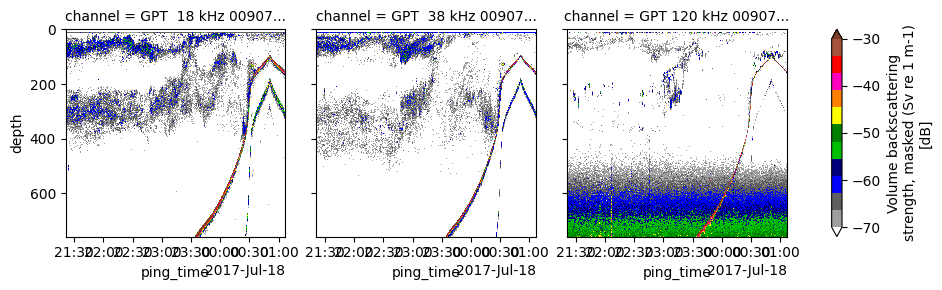

In [99]:
# Plot MVBS clean Hake
ds_MVBS_transect_cleaned_hake["Sv"].plot.pcolormesh(
    col="channel",
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500"
)